# You can also perform analyses on the tracks in your `Dataset` using some of the built in functionality in `trackio`.

In [1]:
import trackio as tio
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gp
import pandas as pd
import numpy as np

In [2]:
#create the Dataset
ds = tio.read(data_path='example00')

# Interpolating raster values to tracks

In [ ]:
#get original track
track_id = ds.tracks.index[51]

#get raster
ras = rio.open('files/sampler.tif')

#interpolate raster values to track
ds = ds.interpolate_raster(ras,
                           name='Raster',
                           tracks=[track_id],
                           method='linear')

#get sampled track
sampled = ds.get_track(track_id)

In [ ]:
#plot sampled track
fig, ax = plt.subplots(1,2)
ax[0].plot(sampled['X'], sampled['Y'])
m = ax[0].scatter(sampled['X'], sampled['Y'], c=sampled['Raster'])
plt.colorbar(m)
ax[1].plot(sampled['Time'], sampled['Raster'])

# Calculating Encounters Between Tracks

Here, an encounter refers to instances where 2 agents were within a spatial and temporal threshold of one another. E.g. Looking in a +/- 30min window, any agents that came within 100m of eachother.

In [ ]:
#calculate spatiotemporal encounters
encounters = ds.encounters(distance=100,
                           time=1800,
                           data_cols=['Speed','Coursing'],
                           meta_cols=['MMSI'],
                           filter_min=True, #only keep minimum encounter for each unique pair of tracks
                           ncores=4)

In [ ]:
encounters.head(5)

In [ ]:
#track ids of first encounter
tid0 = encounters['Track ID_0'].iloc[0]
tid1 = encounters['Track ID_1'].iloc[0]

#tracks
t0 = ds.get_track(tid0)
t1 = ds.get_track(tid1)

#encounter circle
enc = encounters['geometry'].iloc[[0]]

#coords on tracks
x0,y0 = encounters[['X_0', 'Y_0']].iloc[0]
x1,y1 = encounters[['X_1', 'Y_1']].iloc[0]

#plot them
plt.plot(t0['X'], t0['Y'], label=tid0)
plt.scatter(x0,y0)
plt.plot(t1['X'], t1['Y'], label=tid1)
plt.scatter(x1,y1)
enc.plot(ax=plt.gca(), alpha=0.5, label='Encounter')
plt.legend()

#zoom to encounter
center = enc.iloc[0].centroid
dist = encounters['Minimum Distance'].iloc[0] * 3
plt.xlim(center.x-dist, center.x+dist)
plt.ylim(center.y-dist, center.y+dist)

# Calculating Intersections Between Tracks

This differs from an encounter in that the tracks must actually intersect. In this function, you can also specify a temporal threshold, e.g. the tracks of two agents crossed paths within +/-30min of eachother.

This takes a while, so it's smart to filter it down to only tracks you are interested in, or simplify the tracks first.

In [ ]:
#calculate track intersections
intersections = ds.intersections(time=3600,
                                 tracks0=ds.tracks.index[:10], #first 10 tracks
                                 tracks1=ds.tracks.index[:10], #first 10 tracks
                                 data_cols=['Speed','Coursing'],
                                 meta_cols=['MMSI'],
                                 ncores=4)

In [ ]:
intersections.head(5)

In [ ]:
#track ids of first intersection
tid0 = intersections['Track ID_0'].iloc[0]
tid1 = intersections['Track ID_1'].iloc[0]

#tracks
t0 = ds.get_track(tid0)
t1 = ds.get_track(tid1)

#intersection point
inter = intersections['geometry'].iloc[0]

#plot them
plt.plot(t0['X'], t0['Y'], label=tid0)
plt.plot(t1['X'], t1['Y'], label=tid1)
plt.scatter(inter.x, inter.y, c='r', label='Intersection')
plt.legend()

#zoom to encounter
dist = 100
plt.xlim(inter.x-dist, inter.x+dist)
plt.ylim(inter.y-dist, inter.y+dist)

# Proximity to Object

This method calculates the minimum proximity to a shapely object for each track.

In [ ]:
#read the object
line = gp.read_file(r'files/line.gpkg').iloc[0].geometry

#calculate closest proximity to object
distance_to_line = ds.proximity_to_object(line, 
                                          data_cols=['Speed','Coursing'],
                                          meta_cols=['MMSI'],
                                          ncores=4)

In [ ]:
distance_to_line.head()

In [ ]:
#plot the closest points
gdf = ds.to_gdf(ncores=4)
gdf.plot()
plt.plot(*line.xy, c='r', zorder=10)
plt.scatter(distance_to_line['X'], distance_to_line['Y'], c=distance_to_line['Min Distance'], zorder=9)

# Minimum Proximity between Tracks

This method calculates the minimum distance between tracks that overlap in time in the `Dataset`.

The track proximity functions assume `Dataset.resample_time_global` has already been run. If not, the results will be invalid or the function may crash.

In [ ]:
#resample the data to a global time axis
time = pd.date_range('2021-01-01', '2021-01-02', freq='60s')

#temporal resample
ds = ds.resample_time_global(time, 
                             ncores=4)

#refresh meta
ds = ds.refresh_meta(ncores=4)

In [ ]:
#track proximities, minimum distance between tracks
proximities = ds.proximities(data_cols=['Speed','Coursing'],
                             meta_cols=['MMSI'],
                             ncores=4)

In [ ]:
proximities.head(5)

In [ ]:
#get index of closest approach
idx = proximities['Minimum Distance'].argmin()

#closest
row = proximities.iloc[idx]

row

In [ ]:
#get tracks
tid0 = 'Vessel_309987000_T0'#row['Track ID_0']
tid1 = 'Vessel_367179990_T0'#row['Track ID_1']
t0 = ds.get_track(tid0)
t1 = ds.get_track(tid1)

#coords on tracks
x0,y0 = row[['X_0', 'Y_0']]
x1,y1 = row[['X_1', 'Y_1']]

#plot them
plt.plot(t0['X'], t0['Y'], label=tid0)
plt.scatter(x0, y0)
plt.plot(t1['X'], t1['Y'], label=tid1)
plt.scatter(x1, y1)
plt.legend()

#zoom to encounter
dist = row['Minimum Distance'] * 5
plt.xlim(x0-dist, x0+dist)
plt.ylim(y0-dist, y0+dist)

# Binned Proximity between Tracks

This function calculates the amount of time tracks spend with certain distance bins from one another. Similar to the last function but it bins the amount of time spent inside distance bins, rather than just reporting the minimum.

In [ ]:
#track proximities, time spent binned by distance
bins=[10,
      100,
      500,
      1000,
      5000, 
      10000,
      20000,
      30000,
      50000,
      75000,
      100000]

proximities = ds.proximities(ncores=4, 
                             bins=bins,
                             data_cols=['Speed','Coursing'],
                             meta_cols=['MMSI'],
                             relative=False)

# The dataframe holds the amount of time (seconds) spent between each distance bin, for each pair of tracks.

In [ ]:
proximities[['Track ID_0', 
             'Track ID_1']+bins].head(5)

# Relative Binned Proximity between Tracks

This calculates the same binned promixities as the previous function, but for each distance bin it will calculate the relative amount of time spent within that distance bin.

For example, if 2 agents spent 30min within 1km of eachother, but another pair of 2 agents spent 50min within 1km of eachother, then in the context of the entire `Dataset`, 2 agents spent 50min within 1km of eachother.

It provides binned distance proximities at the global `Dataset` level instead of on a track by track basis.

In [ ]:
#calculate relative proximity timings
proximities = ds.proximities(ncores=4, 
                             bins=bins,
                             data_cols=['Speed','Coursing'],
                             meta_cols=['MMSI'],
                             relative=True)

# Here the results are aggregated at each timestep for all tracks passed to the function.

In [ ]:
proximities.head(5)

# To reduce this further, you can sum the times to get a measure of the amount of time spent over the entire duration of your `Dataset`.

In [ ]:
proximities[bins].sum(axis=0)

# The result implies that vessels are very close to one another throughout the dataset. This is likely due to moored vessels at ports/piers that have not been cleaned from the data yet.

# Extracting Lateral Distributions

## This function slices tracks at user-defined cross-sections along a line, and returns the lateral position of agents as well as data fields at those locations. 

In [3]:
#start and end points of line
start = (-8236853, 4969110)
end = (-8235272, 4969359)

#clipping polygon for cross-section intersections
polygon = gp.read_file('files/lateral_clip.gpkg').geometry.iloc[0]

#lateral bin spacing along each cross-section
bins = 10

#spacing or n_slices for spacing between cross-sections
n_slices = 5

#split tracks by direction to/from
split = True


In [4]:
#lets make sure speed and coursing have been computed before extracting
ds = ds.compute_speed(ncores=4)
ds = ds.compute_coursing(ncores=4)
ds = ds.refresh_meta(ncores=4)

Refreshing metadata: 100%|██████████| 163/163 [00:04<00:00, 35.78it/s] 


New meta/databases saved to c:\code\trackio\notebooks\example00


In [5]:
#get the lateral cross sections/slices
lateral = ds.lateral_distribution(start,
                                  end,
                                  n_slices=n_slices,
                                  split=split,
                                  bins=bins,
                                  polygon=polygon,
                                  meta_cols=['MMSI'],
                                  data_cols=['Time', 'Speed', 'Coursing'],
                                  ncores=4)

Calculating lateral distributions at slices: 100%|██████████| 163/163 [00:13<00:00, 12.44it/s]


In [6]:
lateral.head(5)

Lateral Distance  \
Longitudinal Distance Direction                                                      
0.000000              F          [73.58505542492055, 115.16979685298816, -15.20...   
                      T          [-81.72664413760543, 45.1284879718585, 22.8007...   
400.122013            F          [34.26574433007312, 143.466106041165, -37.1176...   
                      T          [-115.18754284932793, -71.12731785232127, -72....   
800.244025            F          [34.20553014799012, 145.9096212050079, -27.823...   

                                                                            TrackX  \
Longitudinal Distance Direction                                                      
0.000000              F          [-8236841.5518178, -8236835.08216589, -8236855...   
                      T          [-8236865.7148306, -8236845.9790207, -8236849....   
400.122013            F          [-8236452.41901966, -8236435.42989557, -823646...   
                      T          [-8236475.67059502, -8236468.81581343, -823646...   
800.244025            F          [-8236057.1783876, -8236039.7997395, -8236066....   

                                                                            TrackY  \
Longitudinal Distance Direction                                                      
0.000000              F          [4969037.31093957, 4968996.23254715, 4969125.0...   
                      T          [4969190.73151457, 4969065.42101082, 4969087.4...   
400.122013            F          [4969138.40148625, 4969030.53078281, 4969208.9...   
                      T          [4969286.03498276, 4969242.51124905, 4969243.3...   
800.244025            F          [4969200.71096725, 4969090.36702066, 4969261.9...   

                                     SliceX      SliceY  \
Longitudinal Distance Direction                           
0.000000              F         -8236853.00  4969110.00   
                      T         -8236853.00  4969110.00   
400.122013            F         -8236457.75  4969172.25   
                      T         -8236457.75  4969172.25   
800.244025            F         -8236062.50  4969234.50   

                                                                              Time  \
Longitudinal Distance Direction                                                      
0.000000              F          [2021-01-01 14:49:44.507705600, 2021-01-01 02:...   
                      T          [2021-01-01 11:24:43.913151744, 2021-01-01 03:...   
400.122013            F          [2021-01-01 14:50:42.506852864, 2021-01-01 02:...   
                      T          [2021-01-01 11:22:19.325794304, 2021-01-01 03:...   
800.244025            F          [2021-01-01 14:51:38.701548288, 2021-01-01 02:...   

                                                                             Speed  \
Longitudinal Distance Direction                                                      
0.000000              F          [6.888409455778374, 3.29476097847569, 4.308658...   
                      T          [2.831286162634015, 5.790285894903349, 8.49119...   
400.122013            F          [7.037795637861195, 3.1032378374425345, 4.3088...   
                      T          [2.720615402151551, 5.63142241954724, 8.427232...   
800.244025            F          [7.174533895478772, 4.546814274559929, 4.29254...   

                                                                          Coursing  \
Longitudinal Distance Direction                                                      
0.000000              F          [70.23898695992672, 79.77378132642892, 72.4879...   
                      T          [247.49279988027223, 244.94497567023913, 243.4...   
400.122013            F          [78.12801425215885, 83.79698404801627, 80.3373...   
                      T          [260.4467840787006, 246.84035613129348, 251.02...   
800.244025            F          [80.59807376349956, 79.43921240431185, 82.8443...   

                                  

Converting tracks to GeoDataFrame: 100%|██████████| 163/163 [00:02<00:00, 73.31it/s]


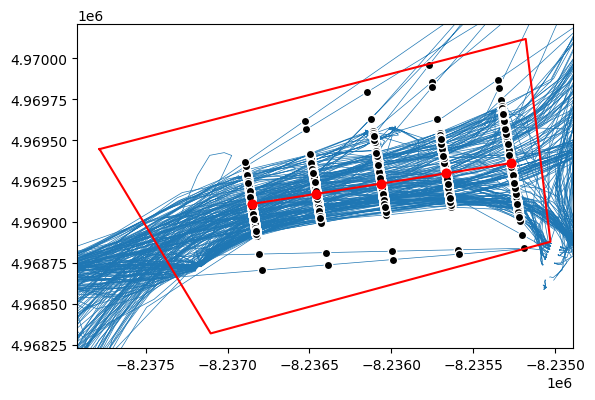

In [7]:
#plot the polygon and line
plt.plot(*polygon.exterior.xy, c='r', zorder=10)
plt.plot(lateral['SliceX'], lateral['SliceY'], '-o', c='r', zorder=10)

#fix the x,y lims
plt.gca().set_xlim(plt.gca().get_xlim())
plt.gca().set_ylim(plt.gca().get_ylim())

#plot the tracks
gdf.plot(linewidth=0.5, ax=plt.gca())

#plot the cross-section intersections
plt.scatter(lateral['TrackX'].explode(),
            lateral['TrackY'].explode(),
            c='k',
            edgecolor='w',
            zorder=9)

In [24]:
x = lateral['TrackX'].explode()
y = lateral['TrackY'].explode()
coursing = lateral['Coursing'].explode()
pd.DataFrame({'x':x, 'y':y, 'c':coursing}).to_csv('test1.csv')

# Now, let's plot the lateral position distributions at one of the slices, as well as distributions of the data fields.

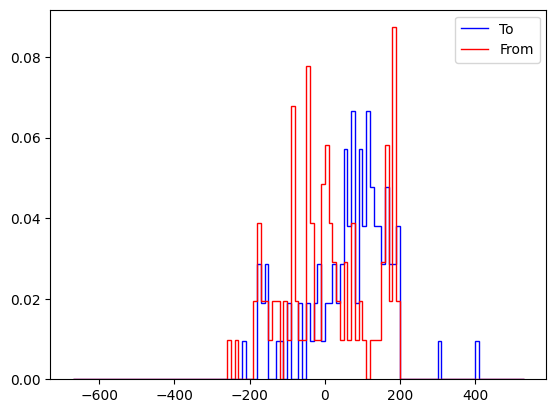

In [8]:
#get the slice
slice0 = lateral.iloc[0] #one way
slice1 = lateral.iloc[1] #the other way

#plot binned lateral positions
plt.stairs(slice0['Frequency'], slice0['Bins'], color='b', label='To')
plt.stairs(slice1['Frequency'], slice1['Bins'], color='r', label='From')
plt.legend()

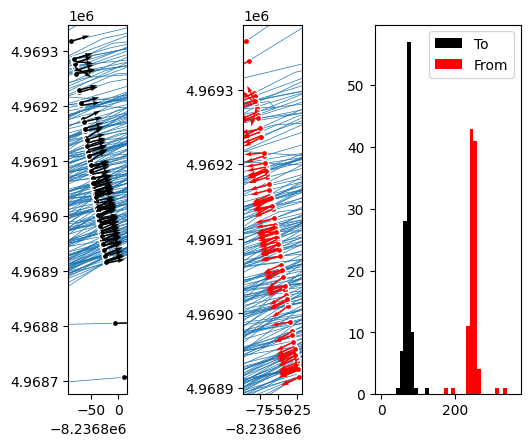

In [88]:
#plot the slice with vectors on the left
fig, ax = plt.subplots(1, 3)
ax[0].scatter(slice0['TrackX'], slice0['TrackY'], c='k', edgecolor='w', s=20)
ax[0].quiver(slice0['TrackX'], 
             slice0['TrackY'],
             np.sin(np.radians(slice0['Coursing'])),
             np.cos(np.radians(slice0['Coursing'])),
             color='k',
             scale=3,
             width=0.025)
ax[1].scatter(slice1['TrackX'], slice1['TrackY'], c='r', edgecolor='w', s=20)
ax[1].quiver(slice1['TrackX'], 
             slice1['TrackY'],
             np.sin(np.radians(slice1['Coursing'])),
             np.cos(np.radians(slice1['Coursing'])),
             color='r',
             scale=3,
             width=0.025)

#fix the xlim, ylim
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim(ax[0].get_ylim())
ax[1].set_xlim(ax[1].get_xlim())
ax[1].set_ylim(ax[1].get_ylim())

# #plot the tracks
gdf.plot(ax=ax[0], linewidth=0.5, zorder=-1)
gdf.plot(ax=ax[1], linewidth=0.5, zorder=-1)

#plot coursing at slice
plt.hist(slice0['Coursing'], bins=range(0,370,10), label='To', color='k')
plt.hist(slice1['Coursing'], bins=range(0,370,10), label='From', color='r')
plt.legend()

# Time Spent in Polygon

This method calculates when and where tracks enter and exit a given polygon, and records the time spent along with other data fields at their entry and exit point(s).

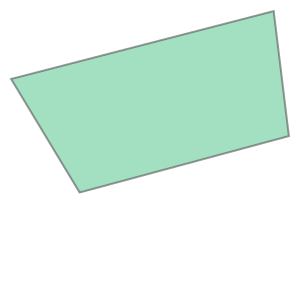

In [4]:
#use the same polygon from the lateral clipping
polygon

In [4]:
#calculate time spent in polygon
time_spent = ds.time_in_polygon(polygon,
                                meta_cols=['MMSI'],
                                data_cols=['Speed','Coursing'],
                                ncores=4)

Computing time spent in polygon:   0%|          | 0/163 [00:00<?, ?it/s]

Computing time spent in polygon: 100%|██████████| 163/163 [00:02<00:00, 63.17it/s]


In [5]:
time_spent.head(5)

,Speed_0,Coursing_0,X_0,Y_0,Time_0,Speed_1,Coursing_1,X_1,Y_1,Time_1,MMSI,Agent ID,Track ID,Duration,Distance Travelled
0,2.705002,236.796648,-8.235104e+06,4.969485e+06,2021-01-01 11:13:16.917398528,2.810406,222.611973,-8.237432e+06,4.968867e+06,2021-01-01 11:28:35.657955328,338295000,Vessel_338295000,Vessel_338295000_T0,918.740556,2463.624907
1,6.784156,53.259523,-8.237367e+06,4.968758e+06,2021-01-01 14:48:16.746665728,6.904409,58.605627,-8.235101e+06,4.969460e+06,2021-01-01 14:53:57.639529472,338329000,Vessel_338329000,Vessel_338329000_T0,340.892863,2399.197043
2,5.689606,60.510527,-8.237370e+06,4.968764e+06,2021-01-01 02:31:18.761738240,4.318408,53.925960,-8.235092e+06,4.969387e+06,2021-01-01 02:41:56.528876544,338357486,Vessel_338357486,Vessel_338357486_T0,637.767138,2387.313130
3,5.257781,238.315910,-8.235136e+06,4.969747e+06,2021-01-01 03:05:44.723743744,5.913885,243.192001,-8.237400e+06,4.968813e+06,2021-01-01 03:13:04.925859840,338357486,Vessel_338357486,Vessel_338357486_T0,440.202116,2455.017433
4,4.667018,45.864512,-8.237396e+06,4.968807e+06,2021-01-01 21:20:39.852719872,4.364159,58.262026,-8.235107e+06,4.969514e+06,2021-01-01 21:29:59.119732480,338458000,Vessel_338458000,Vessel_338458000_T0,559.267012,2436.265329


Text(-8236285.078121668, 4969211.399102353, '2463.624907070488 m\n 918.740556 s')

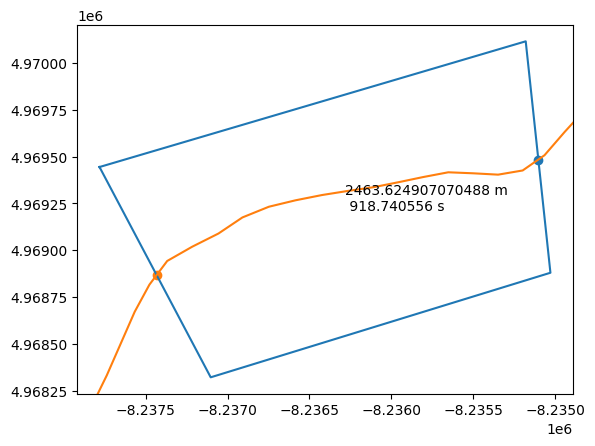

In [6]:
#plot the polygon
plt.plot(*polygon.exterior.xy)

#fix the x,y lims
plt.gca().set_xlim(plt.gca().get_xlim())
plt.gca().set_ylim(plt.gca().get_ylim())

#plot first track inside
first = time_spent.iloc[0]
track = ds.get_track(first['Track ID'])
plt.plot(track['X'], track['Y'])

#plot first entry/exit
plt.scatter(*first[['X_0', 'Y_0']])
plt.scatter(*first[['X_1', 'Y_1']])

#plot stats
plt.text(polygon.centroid.x,
         polygon.centroid.y, 
         f"{first['Distance Travelled']} m\n {first['Duration']} s")


# Notice how the entry/exit points aren't exactly on the polygon perimeter. You can improve the accuracy of these time in polygon estimates by running the `Dataset.imprint_geometry` method first.

In [7]:
#imprint the polygon
ds = ds.imprint_geometry(polygon,
                         ncores=4)

Imprinting geometry into tracks: 100%|██████████| 163/163 [00:02<00:00, 56.14it/s]


In [8]:
#redo the calculation
time_spent = ds.time_in_polygon(polygon,
                                meta_cols=['MMSI'],
                                data_cols=['Speed','Coursing'],
                                ncores=4)

Computing time spent in polygon: 100%|██████████| 163/163 [00:02<00:00, 71.62it/s]


Text(-8236285.078121668, 4969211.399102353, '2463.624907070488 m\n 918.740556 s')

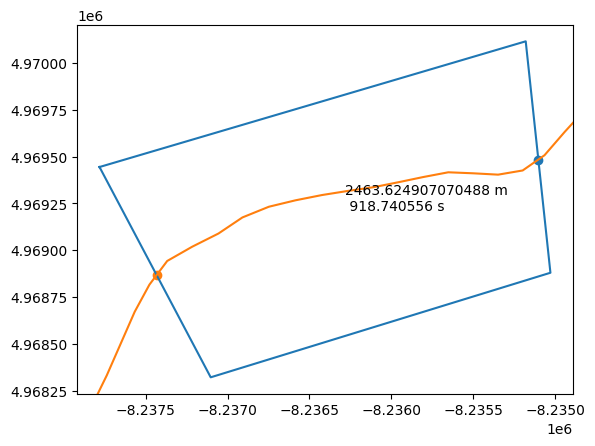

In [9]:
#plot the polygon
plt.plot(*polygon.exterior.xy)

#fix the x,y lims
plt.gca().set_xlim(plt.gca().get_xlim())
plt.gca().set_ylim(plt.gca().get_ylim())

#plot first track inside
first = time_spent.iloc[0]
track = ds.get_track(first['Track ID'])
plt.plot(track['X'], track['Y'])

#plot first entry/exit
plt.scatter(*first[['X_0', 'Y_0']])
plt.scatter(*first[['X_1', 'Y_1']])

#plot stats
plt.text(polygon.centroid.x,
         polygon.centroid.y, 
         f"{first['Distance Travelled']} m\n {first['Duration']} s")

# generate flow map, reduce to flow map